In [1]:
# notebook last tested with abtem version 1.0.0beta32
%matplotlib inline
import os
from abtem import __version__
print('current version:', __version__)

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import ase.data
import matplotlib.pyplot as plt
from scipy import constants
from abtem import *
import numpy as np
import uuid


/zhome/ab/7/153983/project/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


current version: 1.0.0beta32


In [2]:
def generate_image(phi1 = 0, 
                   Phi = 0, 
                   phi2 = 0, 
                   path = "Images",
                   atom_nr = 32000, 
                   gridpoints = 8192,
                   dpi_val = 217, 
                   power_ilum = 0.25):
    
    center_type = 'cop' 
    surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)] # Nanoparticle facets # ASK
    esurf = [1.0, 1.1, 0.9] # Relative surface energies # ASK
    size = atom_nr # Target number of atoms
    atoms = Atoms(wulff_construction('Au', surfaces, esurf, size, 'fcc', rounding='above')) # ASK
    atoms.euler_rotate(phi1, Phi, phi2, center = center_type)
    atoms.center(vacuum=5.) 
    atoms.center(vacuum=2., axis=2) 
    
#     gridpoints = int(max(atoms.cell[0,0], atoms.cell[1,1]) / 0.05)
#     gridpoints = 8192
    
    angle = 2*4.5e-3
    defocus = 40/np.sin(angle)

    mass = ase.data.atomic_masses[ase.data.atomic_numbers['Au']]
    TD = 165  # Kittel
    T = 300
    U_squared = (3 * constants.hbar**2 / (2 *  mass * ase.units._amu * constants.k * TD)
                 * (1/4 + T / TD))
    sigmas = {'Au': np.sqrt(U_squared) * 1e10} # standard deviations of thermal vibrations
    print(sigmas)
    num_configs = 10 # number of frozen phonon configurations

    frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)

    for i,config in enumerate(frozen_phonons):

        potential = Potential(config, 
                              gpts=gridpoints, 
                              slice_thickness=0.5, 
                              device='gpu',
                              #storage='cpu',
                              precalculate=False,
                              parametrization='kirkland', 
                              projection='infinite') # ASK

        probe = Probe(sampling=potential.sampling,
            device='gpu',
            semiangle_cutoff=1000*angle,
            extent=potential.extent,
            defocus=defocus,
            energy=30000 # acceleration voltage in eVhttp://localhost:8080/notebooks/Kikuchi.ipynb#
        )
        positions = (45, 45)

        exit_wave = probe.multislice(positions, potential)
        cbed_diffraction_pattern = exit_wave.diffraction_pattern(block_zeroth_order=0)

        if (i==0):
            summedImage = cbed_diffraction_pattern.array
        else:
            summedImage += cbed_diffraction_pattern.array


    cbed_diffraction_pattern.array[:] = summedImage/num_configs

    energy = probe.energy
    del probe

    if True:
        exit_wave._array = exit_wave._array.get()
        exit_wave._device = 'cpu'

    ax, im = cbed_diffraction_pattern.show(power = power_ilum)

    plt.axis('off')
     
    if not os.path.exists(path):
        os.makedirs(path)
        
    random_id = uuid.uuid1()
    random_id_str = random_id.hex
     
    plt.savefig('{}/{}'.format(path, "{}_{}_{}_{}.png".format(random_id_str,phi1,Phi,phi2)), bbox_inches='tight', dpi=dpi_val)

{'Au': 0.0680474303682167}


Multislice: 100%|█████████████████████████████████████████████████████████████████████| 153/153 [00:04<00:00, 32.29it/s]


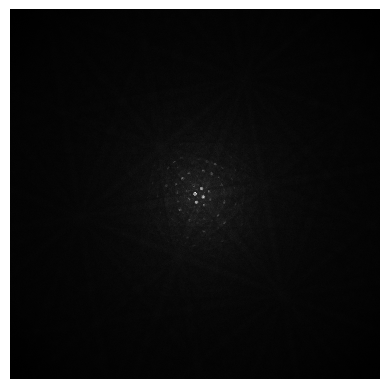

In [3]:
generate_image(phi1=137.4, Phi=54.8, phi2=199, atom_nr = 16000, gridpoints = 6144, power_ilum = 0.27)

In [4]:
import uuid
random_id = uuid.uuid1()
random_id_str = random_id.hex
random_id_str

'0957dc4e891511ed9d3298f2b3f325c4'